# Сопоставление фотографий керна

* [Задача](#Задача)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Валидация](#Валидация)

## Задача

Найти пары фотографий керна в дневном и ультрафиолетовом свете, которые не соответствуют друг другу (смещены, перевернуты, растянуты и пр.)

## Датасет

В датасет включены данные по трем скважинам. Каждая скважина представлена набором снимков керна в дневном и ультрафиолетовом свете, а также разметка пар снимков. Пары без дефектов отмечены 1, с дефектами - 0.

Пример хорошей пары:

In [1]:
from utils import plot_pair, make_data, show_images

plot_pair('/notebooks/data/processed_dataset/417', '417_2356.58_2357.56.png')

<Figure size 500x1500 with 2 Axes>

Пример плохой пары:

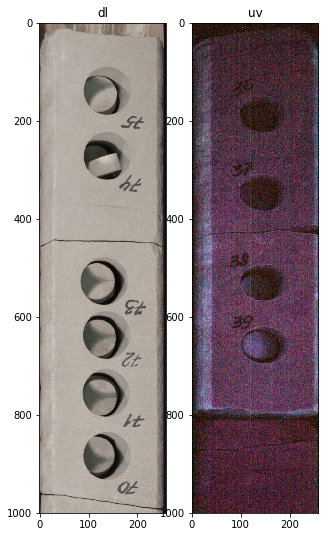

In [2]:
plot_pair('/notebooks/data/processed_dataset/417', '417_2360.6_2361.35.png')

Для решения задачи был написан `CoreBatch` с загрузчиком данных и необходимыми аугментациями.

In [3]:
import os
import sys
import glob

from PIL import Image

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from well_logs import CoreBatch
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18

In [44]:
PATH = '/notebooks/data/processed_dataset/*'

index = FilesIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка данных

Загрузим файл с разметкой и обратим метки: теперь 1 соответствует плохой паре

In [45]:
df = pd.concat([pd.read_feather(filename) for filename in glob.glob(PATH+'/samples.feather')])
df['QC'] = 1 - df['QC']
df = df.set_index('SAMPLE')

Удалим из индекса все плохие пары, чтобы использовать только хорошие и их аугментированные варианты.

In [46]:
index = index.create_subset(np.intersect1d(df.index.values[df['QC'] == 0], index.indices))
ds = Dataset(index, CoreBatch)

Обучение будем производить на кропах следующего размера:

In [47]:
SHAPE = (2, 400, 150)

Чтобы избежать ошибок удалим из инднекса все пары изображений, у которых нне совпадают размеры:

In [48]:
shape_ppl = (ds.p
     .load()
     .check_shapes()
     .init_variable('quality', init_on_each_run=list)
     .update_variable('quality', B('check'), mode='e')
     .init_variable('shape1', init_on_each_run=list)
     .update_variable('shape1', B('s1'), mode='e') 
     .init_variable('shape2', init_on_each_run=list)
     .update_variable('shape2', B('s2'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

shape_ppl.run()

mask = np.array(shape_ppl.get_variable('quality'))
ds.indices[mask]
np.array(shape_ppl.get_variable('shape1'))[mask]
np.array(shape_ppl.get_variable('shape2'))[mask]

shape_df = df.copy().loc[ds.indices]
shape_df['DL_SHAPE'] = shape_ppl.get_variable('shape1')
shape_df['UV_SHAPE'] = shape_ppl.get_variable('shape2')

shape_df.loc[ds.indices[np.array(shape_ppl.get_variable('quality'))]]

COMMENT  DEPTH_FROM  DEPTH_TO  QC     DL_SHAPE  \
SAMPLE                                                                   
215_204.png                 NaN     2925.80   2926.05   0   [259, 623]   
215_232.png                 NaN     3010.60   3010.89   0   [259, 721]   
417_2507.98_2509.05.png     NaN     2507.98   2509.05   0  [259, 2672]   
417_2790.03_2791.16.png     NaN     2790.03   2791.16   0  [259, 2800]   
611_10.png                 None     2451.38   2452.39   0  [259, 2570]   
611_101.png                None     2954.00   2954.96   0  [177, 2427]   
611_102.png                None     2954.96   2955.94   0  [177, 2474]   
611_104.png                None     2957.00   2957.97   0  [177, 2455]   
611_105.png                None     2957.97   2958.89   0  [177, 2330]   
611_110.png                None     2970.00   2970.98   0  [177, 2476]   
611_111.png                None     2970.98   2971.96   0  [177, 2474]   
611_113.png                None     2998.00   2998.98   0  [177, 2478]   
611_114.png                None     2998.98   2999.97   0  [177, 2501]   
611_115.png                None     2999.97   3000.92   0  [177, 2401]   
611_116.png                None     3000.92   3001.90   0  [177, 2482]   
611_117.png                None     3001.90   3002.47   0  [177, 1437]   
611_118.png                None     3145.00   3145.97   0  [177, 2452]   
611_119.png                None     3145.97   3146.95   0  [177, 2475]   
611_121.png                None     3147.95   3148.94   0  [177, 2505]   
611_123.png                None     3149.94   3150.93   0  [177, 2500]   
611_13.png                 None     2455.48   2456.46   0  [259, 2479]   
611_15.png                 None     2457.46   2458.47   0  [259, 2567]   
611_16.png                 None     2458.47   2459.45   0  [259, 2477]   
611_17.png                 None     2459.45   2460.40   0  [259, 2398]   
611_18.png                 None     2460.50   2461.46   0  [259, 2428]   
611_20.png                 None     2462.46   2463.43   0  [259, 2451]   
611_21.png                 None     2463.43   2464.42   0  [259, 2502]   
611_24.png                 None     2466.42   2467.36   0  [259, 2374]   
611_25.png                 None     2508.00   2508.96   0  [259, 2432]   
611_28.png                 None     2510.96   2511.95   0  [259, 2497]   
...                         ...         ...       ...  ..          ...   
611_52.png                 None     2786.50   2787.45   0  [259, 2403]   
611_54.png                 None     2878.00   2878.97   0  [177, 2452]   
611_55.png                 None     2878.97   2879.94   0  [177, 2452]   
611_57.png                 None     2880.91   2881.88   0  [177, 2455]   
611_58.png                 None     2881.88   2882.84   0  [177, 2429]   
611_61.png                 None     2885.00   2885.97   0  [177, 2450]   
611_62.png                 None     2885.97   2886.94   0  [177, 2453]   
611_64.png                 None     2887.94   2888.86   0  [177, 2328]   
611_67.png                 None     2891.00   2891.95   0  [177, 2404]   
611_68.png                 None     2891.95   2892.91   0  [177, 2429]   
611_69.png                 None     2892.91   2893.89   0  [177, 2477]   
611_70.png                 None     2893.89   2894.84   0  [177, 2404]   
611_73.png                 None     2897.00   2897.98   0  [177, 2478]   
611_74.png                 None     2897.98   2898.97   0  [177, 2506]   
611_75.png                 None     2898.97   2899.93   0  [177, 2422]   
611_76.png                 None     2899.93   2900.89   0  [177, 2421]   
611_77.png                 None     2901.00   2901.98   0  [177, 2477]   
611_78.png                 None     2901.98   2902.96   0  [177, 2478]   
611_79.png                 None     2902.96   2903.95   0  [177, 2506]   
611_81.png                 None     2904.94   2905.92   0  [177, 2475]   
611_86.png                 None     2909.97   2910.40   0  [177, 1080]   
611_87.png                 N

Удалим маленькие изображения, из которых нельзя вырезать кроп заданного размера

In [49]:
short_ppl = (ds.p
     .load()
     .short_cores(SHAPE[1:])
     .init_variable('short', init_on_each_run=list)
     .update_variable('short', B('short'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

short_ppl.run()

long_index = ds.index.create_subset(
    ds.indices[np.logical_not(short_ppl.get_variable('short') or shape_ppl.get_variable('quality'))]
)

In [50]:
filtered_df = Dataset(long_index, CoreBatch)
filtered_df.split(shuffle=True)

In [51]:
len(filtered_df)

553

## Архитектура

Для предсказания будем использовать ResNet18 в базовом варианте

# Обучение

In [52]:
BATCH_SIZE = 64
N_EPOCH = 200

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 2,
                'initial_block/inputs': 'images',
                'optimizer': 'Adam',
                'output': 'proba',
                'device': 'gpu:0',
                'loss': 'ce'}

При обучении будем использовать два типа аугментаций: отражение изображений по горизонтали и перемешивание фотографий, поскольку это два наиболее частых и плохих дефекта изображений. Также переведем изображения в ч/б.

In [53]:
well_stat = dict()

for well_path in glob.glob(PATH):
    well_stat[well_path] = {'dl': [], 'uv': []}
    for image in glob.glob(os.path.join(well_path, 'samples_uv', '*')):
        img = np.array(Image.open(image))
        well_stat[well_path]['uv'].append(img.flatten())
    for image in glob.glob(os.path.join(well_path, 'samples_dl', '*')):
        img = np.array(Image.open(image))
        well_stat[well_path]['dl'].append(img.flatten())
    well_stat[well_path]['dl'] = np.concatenate(well_stat[well_path]['dl'])
    well_stat[well_path]['uv'] = np.concatenate(well_stat[well_path]['uv'])

In [54]:
percentile = 90
bounds = dict()
for well in well_stat:
    bounds[well.split('/')[-1]] = {'dl': np.percentile(well_stat[well]['dl'], percentile),
                    'uv': np.percentile(well_stat[well]['uv'], percentile)}

In [55]:
bounds

{'215': {'dl': 158.0, 'uv': 36.0},
 '3311': {'dl': 160.0, 'uv': 30.0},
 '417': {'dl': 176.0, 'uv': 20.0},
 '509': {'dl': 177.0, 'uv': 19.0},
 '604': {'dl': 191.0, 'uv': 48.0},
 '611': {'dl': 168.0, 'uv': 27.0}}

In [56]:
load_ppl = (Pipeline().load(bw=True).normalize(bounds=bounds))

with Pipeline() as p:
    augmentation_ppl = p.flip(p=0.3) + p.shuffle(p=0.3)

In [57]:
train_template = (Pipeline()
     .to_array(src='uv', dst='uv', channels='first')
     .to_array(src='dl', dst='dl', channels='first')
     .random_crop(shape=SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', model_config)
     .init_variable('loss', init_on_each_run=list)
     .concatenate()
     .train_model('model', B('images'), B('labels'), fetches='loss',
                 save_to=V('loss', mode='a'))
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=N_EPOCH,
        shuffle=True,
        drop_last=True,
        lazy=True,
        bar=True
    )
)

In [58]:
train_ppl = (load_ppl + augmentation_ppl + train_template) << filtered_df.train

In [59]:
train_ppl.run()
train_ppl.get_model_by_name('model').save('resnet16.torch')

with open('loss', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss'), f)

with open('dataset', 'wb') as f:
    pickle.dump(filtered_df, f)

100%|██████████| 1200/1200 [32:32<00:00,  1.66s/it]


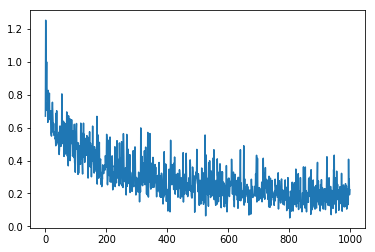

In [20]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)
    
with open('dataset', 'rb') as f:
    filtered_df = pickle.load(f)

plt.plot(loss)
plt.show()

## Валидация

Сначала провалидируемся на кропах

In [21]:
test_template = (Pipeline()
     .to_array(src='uv', dst='uv', channels='first')
     .to_array(src='dl', dst='dl', channels='first')
     .random_crop(SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:1', 'load/path': 'resnet16.torch'
                })
     .init_variable('loss', init_on_each_run=list)
     .concatenate()
     .init_variable('proba', init_on_each_run=None)
     .init_variable('metrics', init_on_each_run=None)
     .predict_model('model', B('images'), targets=B('labels'), fetches='proba', save_to=B('proba', mode='w'))
     .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                     fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=10,
        shuffle=True,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [22]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << filtered_df.test

In [23]:
b = test_ppl.next_batch()

Посмотрим на примеры предсказаний

604_59.png
Label:  1.0   Prediction:0.6696338


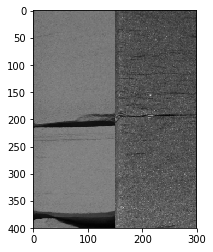

604_59.png
Label:  1.0   Prediction:0.6696338


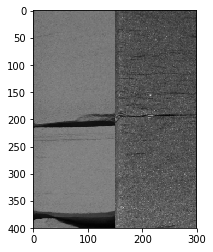

509_96.png
Label:  1.0   Prediction:0.99959666


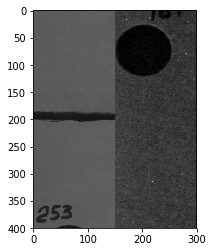

417_2786.24_2787.4.png
Label:  1.0   Prediction:0.8502948


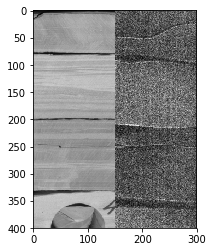

215_237.png
Label:  0.0   Prediction:0.085846104


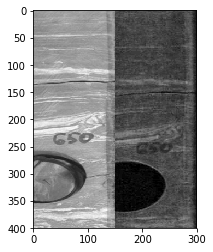

215_129.png
Label:  1.0   Prediction:0.96804863


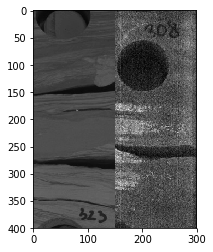

215_42.png
Label:  1.0   Prediction:0.5934592


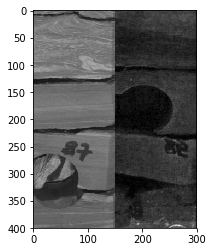

611_112.png
Label:  0.0   Prediction:0.95521516


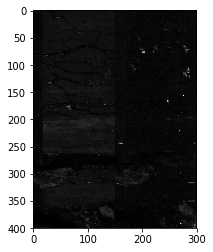

215_143.png
Label:  1.0   Prediction:0.99338645


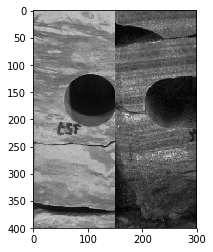

611_102.png
Label:  0.0   Prediction:0.00749317


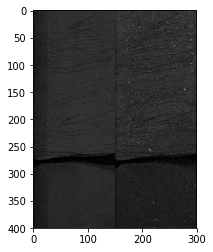

In [67]:
for i in np.random.choice(b.dl.shape[0], 10):
    img1 = np.squeeze(b.dl[i])
    img2 = np.squeeze(b.uv[i])
    print(b.indices[i])
    print('Label: ', str(b.labels[i]) + '   Prediction:' + str(b.proba[i][1]))
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1), cmap='gray')
    plt.show()

In [68]:
test_ppl.reset_iter()
test_ppl.run()

metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

[[[355  17]
  [147 591]]]
specificity : 0.7071713147410359
sensitivity : 0.9720394736842105
accuracy : 0.8522522522522522


# Провалидируемся на целых изображениях

In [69]:
from utils import assemble, assemble_stat

In [70]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200)
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:2', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                   save_to=B('proba', mode='w'))
    .call(assemble_stat, save_to=B('all_proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=8,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [71]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << filtered_df.test

In [72]:
test_ppl.reset_iter()
test_ppl.run()

In [73]:
metrics = test_ppl.get_variable('metrics')
metrics._confusion_matrix

array([[[35,  1],
        [14, 61]]])

In [74]:
for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

specificity : 0.7142857142857143
sensitivity : 0.9838709677419355
accuracy : 0.8648648648648649


In [75]:
stat = test_ppl.get_variable('stat')
dl_images = np.concatenate([item[0] for item in stat])
uv_images = np.concatenate([item[1] for item in stat])
proba = np.concatenate([item[2] for item in stat])
labels = np.concatenate([item[3] for item in stat])

In [76]:
false_negative = [i for i in range(len(labels)) if (labels[i] == 1) & (proba[i][1] < 0.5)]
false_positive = [i for i in range(len(labels)) if (labels[i] == 0) & (proba[i][1] > 0.5)]

true_negative = [i for i in range(len(labels)) if (labels[i] == 0) & (proba[i][1] < 0.5)]
true_positive = [i for i in range(len(labels)) if (labels[i] == 1) & (proba[i][1] > 0.5)]  

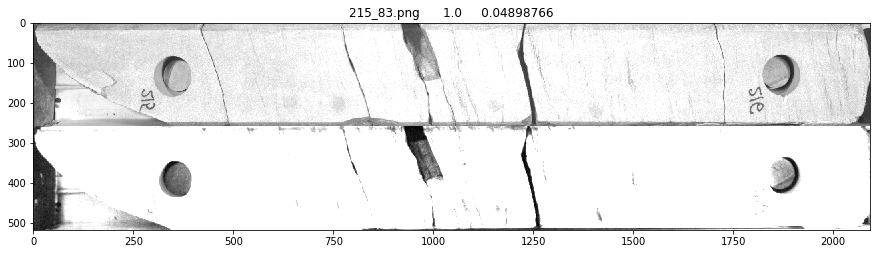

In [77]:
index = test_ppl.dataset.indices

for i in false_negative:
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()

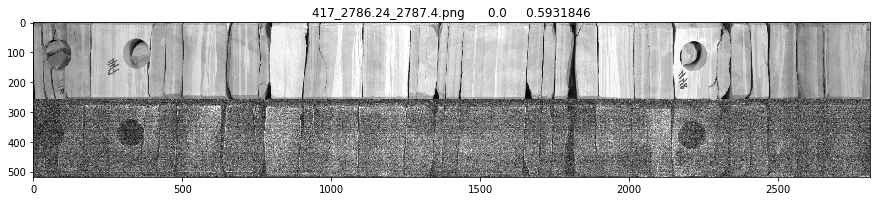

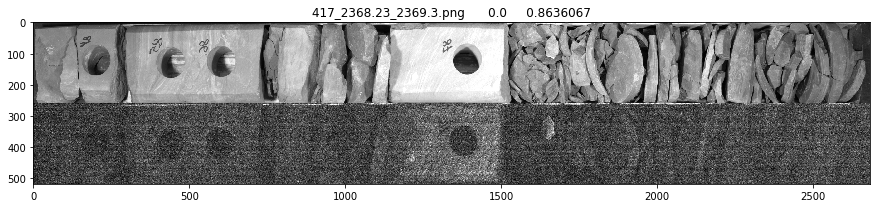

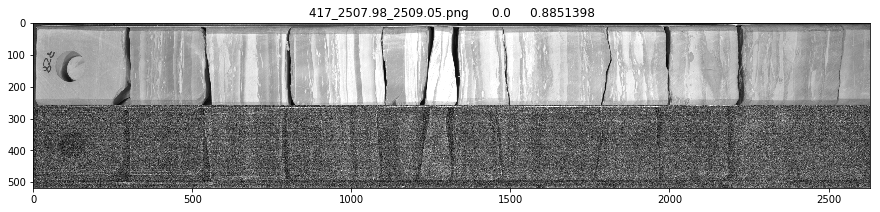

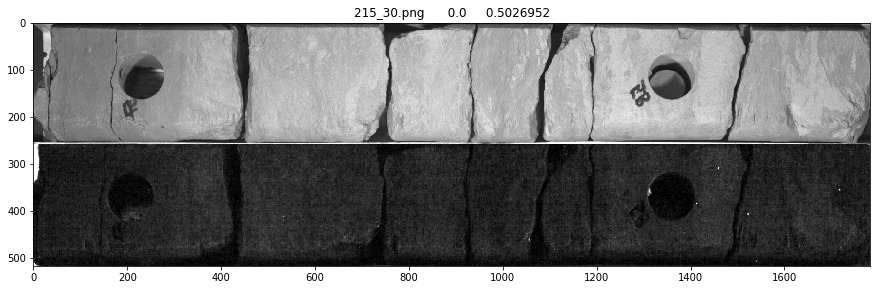

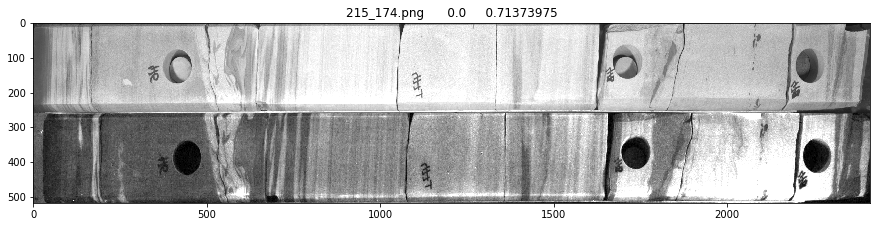

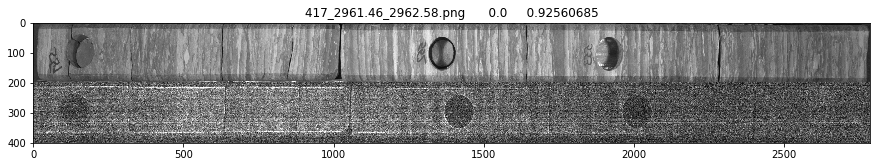

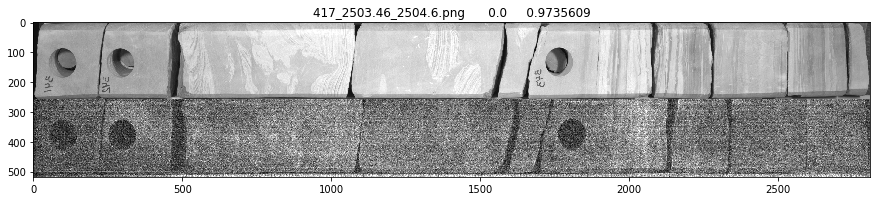

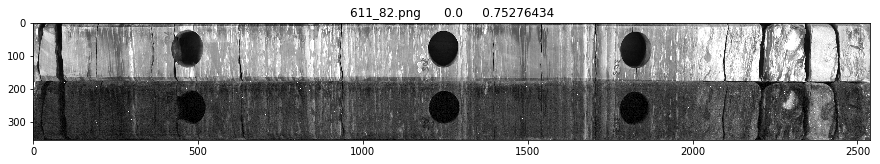

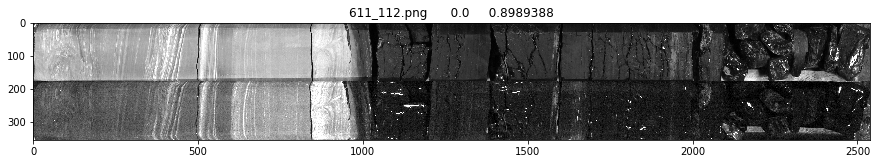

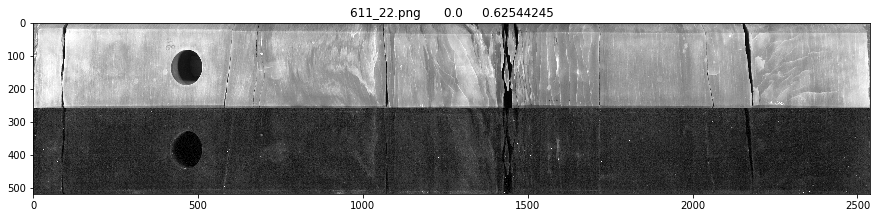

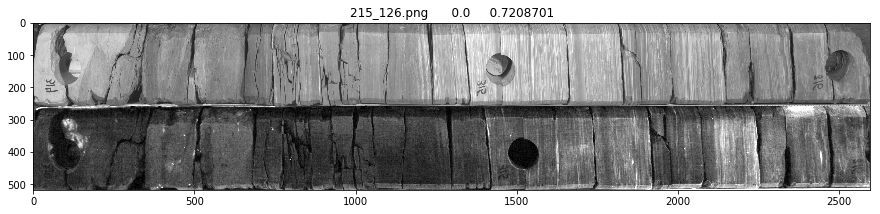

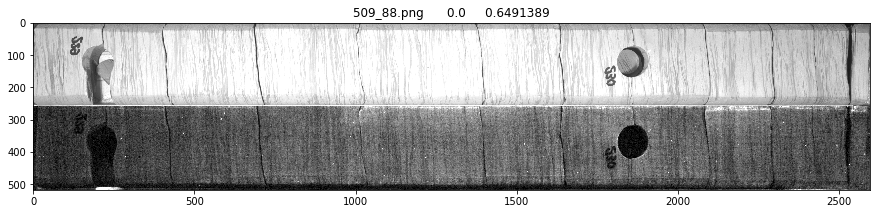

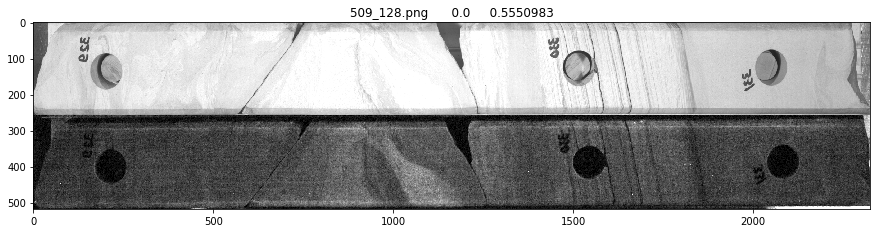

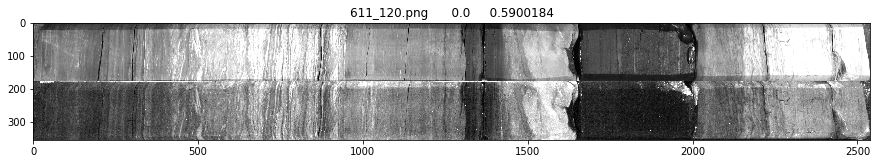

In [78]:
index = test_ppl.dataset.indices

for i in false_positive:
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()

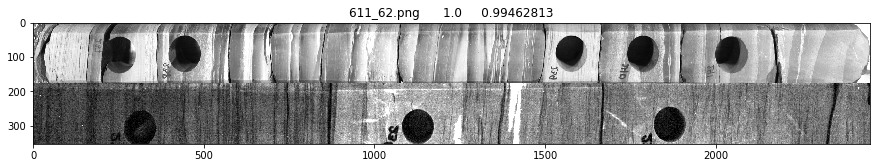

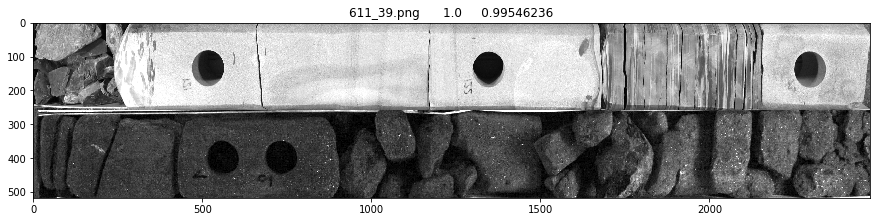

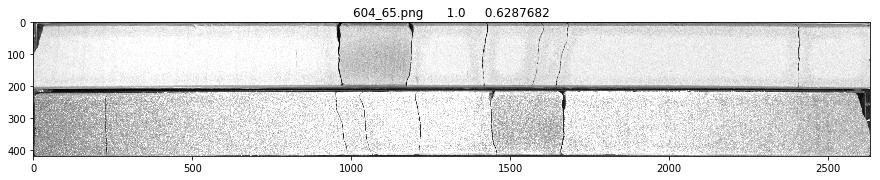

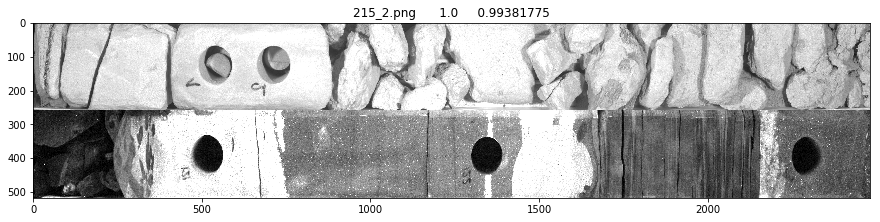

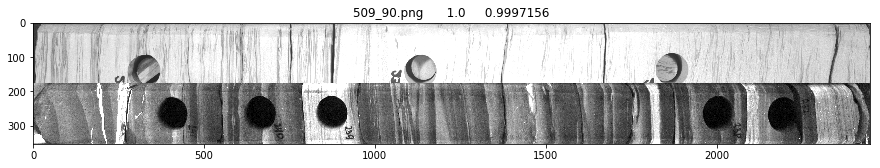

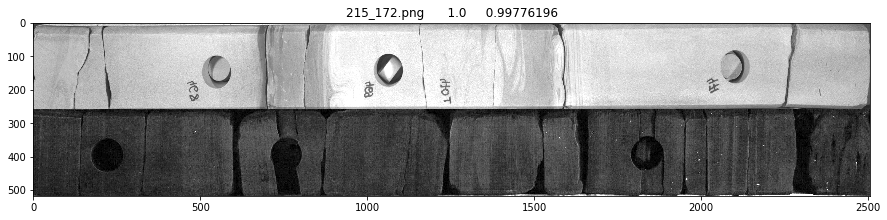

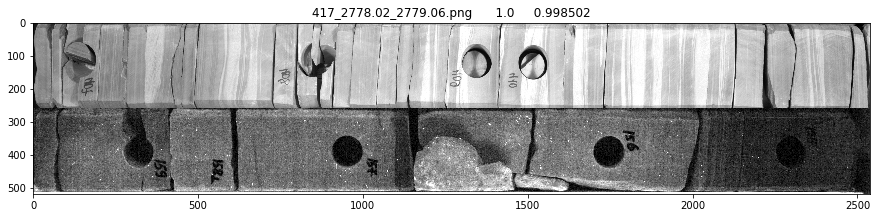

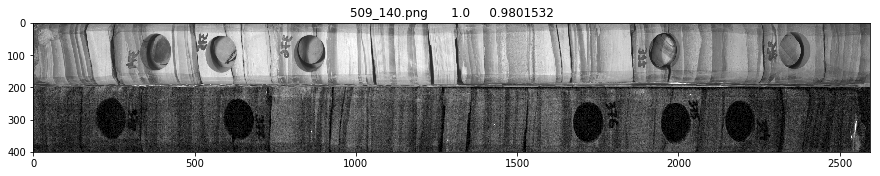

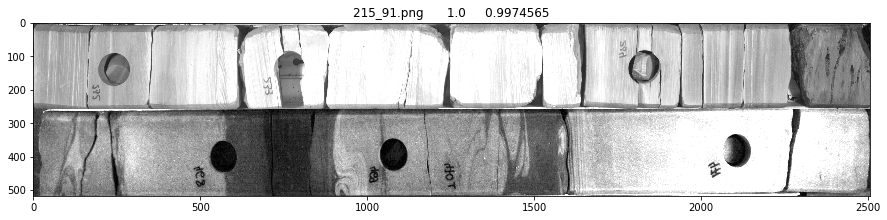

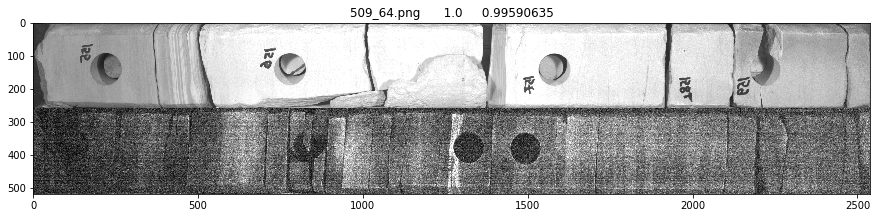

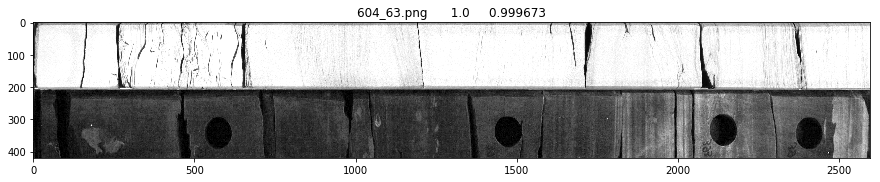

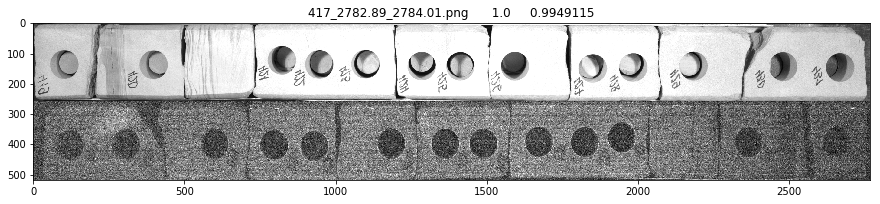

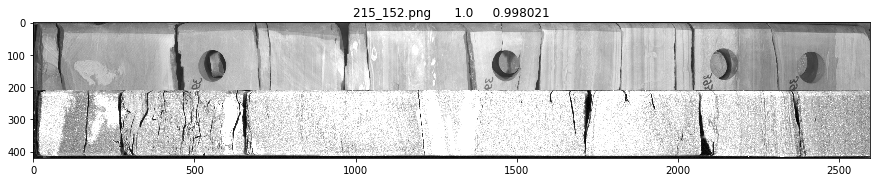

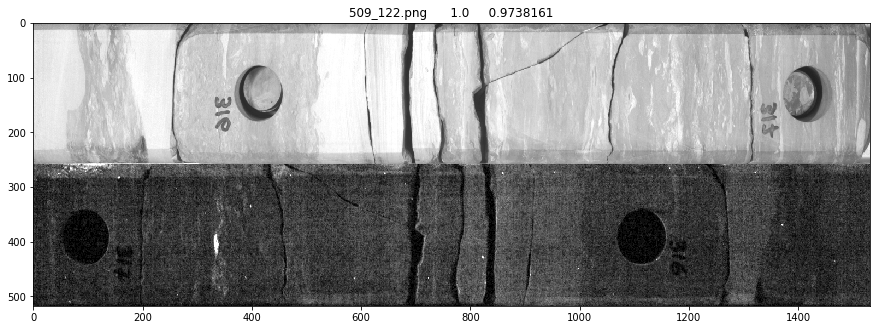

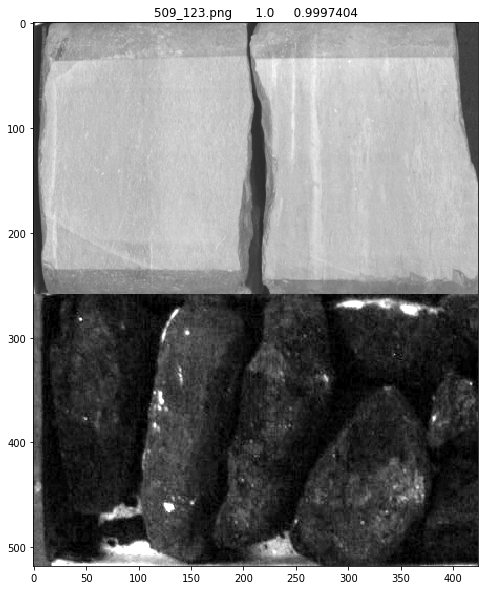

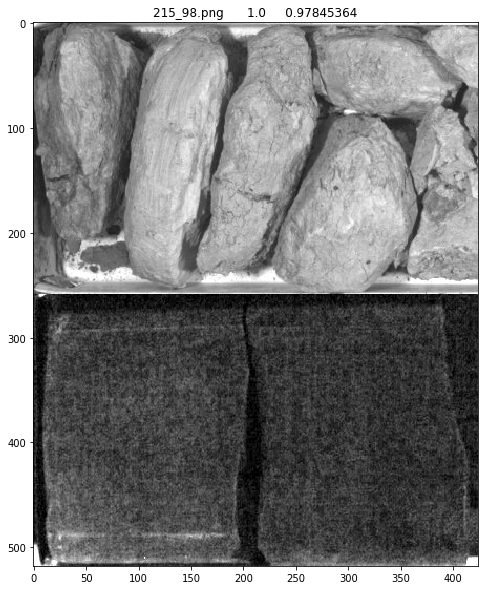

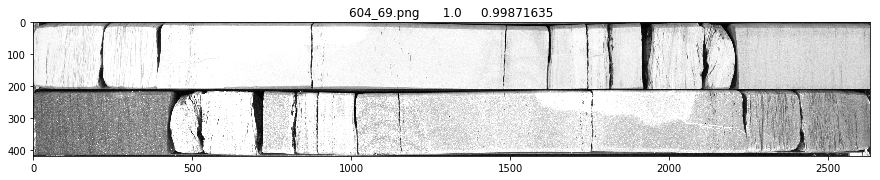

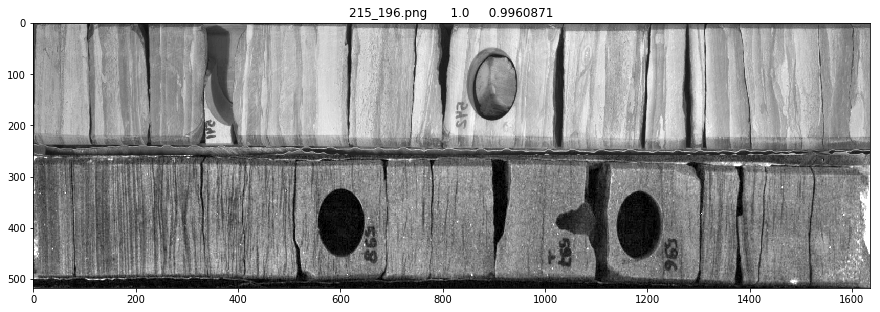

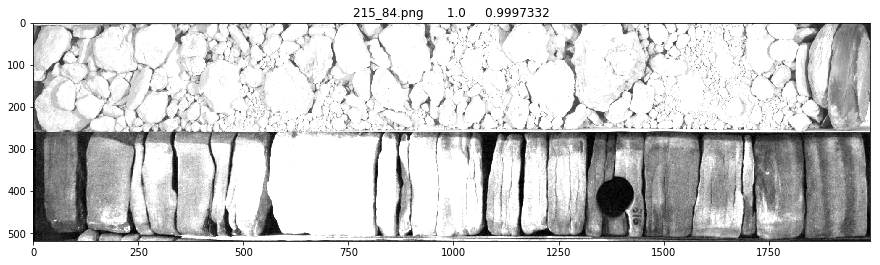

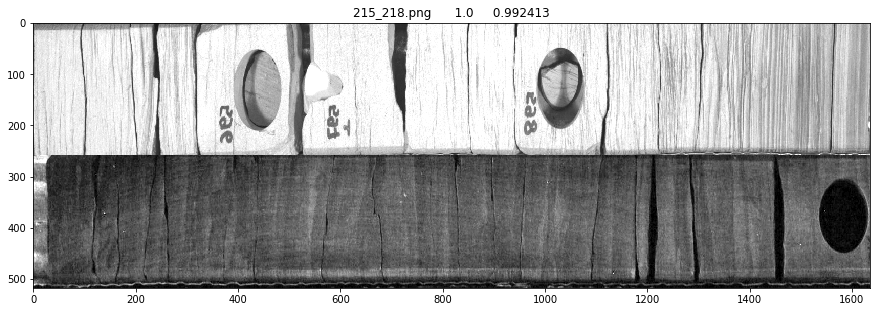

In [79]:
index = test_ppl.dataset.indices

for i in true_positive[:20]:
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()